In [1]:
import sys
import os, errno
import os.path
from os import path
import shutil

import numpy as np
import pandas as pd
import h5py
import csv

from matplotlib import pyplot as plt

In [2]:
WORKSPACE_PATH   = os.getenv('WORKSPACE_PATH')  

PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/O3_UMN.hdf5'
PathToGroupsFile = WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/Bins_45/LevelsMap_InelAmal45.csv'
#PathToGroupsFile = WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/Bins_45/LevelsMap_RVE45.csv'

TVec             = np.array([2500.0, 5000.0, 10000.0, 15000.0, 20000.0])
T                = 10000.
NProcTypes       = 3
CFDCompName      = 'O2'

NSamples         = 45
MinRatesVec      = [5.e-13, 1.e-13]

In [3]:
PathToFile    = PathToHDF5File
HDF5Exist_Flg = path.exists(PathToFile)
if (HDF5Exist_Flg):
    f = h5py.File(PathToFile, 'a')
else:
    f = {'key': 'value'}

TempStr = CFDCompName   
grp     = f[TempStr]

Data                          = grp["NLevels"]
NLevels   = Data[...][0]
Data                          = grp["Levelvqn"]
Levelvqn  = Data[...]
Data                          = grp["Leveljqn"]
Leveljqn  = Data[...]
Data                          = grp["LevelEEh"]
LevelEEh  = Data[...]
Data                          = grp["LevelEeV"]
LevelEeV  = Data[...]
Data                          = grp["LevelEgam"]
LevelEgam = Data[...]
Data                          = grp["LevelrMin"]
LevelrMin = Data[...]
Data                          = grp["LevelrMax"]
LevelrMax = Data[...]
Data                          = grp["LevelVMin"]
LevelVMin = Data[...]
Data                          = grp["LevelVMax"]
LevelVMax = Data[...]
Data                          = grp["LevelTau"]
LevelTau  = Data[...]
Data                          = grp["LevelrIn"]
LevelrIn  = Data[...]
Data                          = grp["LevelrOut"]
LevelrOut = Data[...]

In [4]:
Data       = pd.read_csv(PathToGroupsFile)
LevelToBin = Data.Group.to_numpy(int) - 1
NGroups    = np.amax(LevelToBin)+1

In [5]:
PathToFile    = PathToHDF5File
HDF5Exist_Flg = path.exists(PathToFile)
if (HDF5Exist_Flg):
    f = h5py.File(PathToFile, 'a')
else:
    f = {'key': 'value'}

TStr = 'T_' + str(int(T)) + '_' + str(int(T)) + '/RatesMicroRev/'
grp  = f[TStr]

Data      = grp["Diss"]
DissRates = Data[...]
Data      = grp["Inel"]
InelRates = Data[...]

for iProc in range(2, NProcTypes):
    ExchStr   = "Exch_" + str(iProc-1)
    Data      = grp[ExchStr]
    ExchRates = Data[...]

f.close()

Rates   = InelRates + 1.e-100 #+ ExchRates
NLevels = Rates.shape[0]
Levels  = np.arange(NLevels)

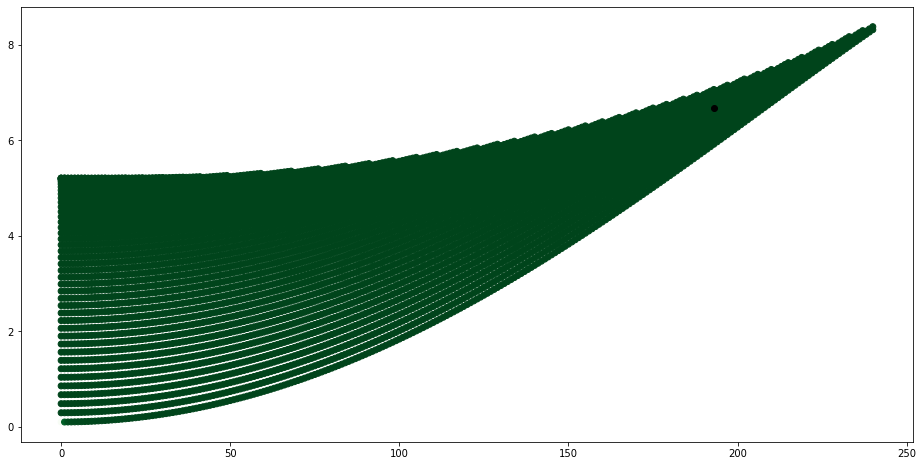

In [6]:
iLevel = 0

pp     = np.exp( - (Rates[iLevel,:] - Rates[iLevel,iLevel])**2 / Rates[iLevel,iLevel]**2 )
p      = pp/np.sum(pp)

# Vec    = Rates[iLevel,:]
# Vec[iLevel] = 0.0
# pp     = 1. - Vec/np.sum(Vec)
# p      = pp/np.sum(pp)

jLevel = np.random.choice(Levels, 1, p=p)

fig = plt.figure(figsize=(16,8))
plt.scatter(Leveljqn, LevelEeV, c=p, cmap='Greens_r')
plt.scatter(Leveljqn[jLevel], LevelEeV[jLevel], c='k')

In [7]:
iMin  = np.argmin(LevelEeV)
iLeft = np.argmax(LevelEeV)
iMax  = np.argmax(LevelTau)

for iLevel in range(NLevels):
    if (Levelvqn[iLevel] == 0) and (Leveljqn[iLevel] == 1):
        ivZero = iLevel
        break
        
for iLevel in range(NLevels):
    if (Levelvqn[iLevel] == 1) and (Leveljqn[iLevel] == 0):
        ijZero = iLevel
        break

In [8]:
MinRate    = MinRatesVec[0] + (T - TVec[0])*(MinRatesVec[1] - MinRatesVec[0])/(TVec[1] - TVec[0])
print(MinRate)

-6.999999999999999e-13


In [9]:
p2         = np.zeros(NLevels)
Vec        = np.zeros(NLevels)
LevelsVec  = []
iIter      = 0
for iLevel in [ijZero, ivZero, iLeft, iMax]:
    
    p1     = 1. / np.maximum(Rates[iLevel,:], MinRate)
    p2    += p1 / np.sum(p1) 
    p      = p2 / (iIter+1)
    
#     Vec    = Rates[iLevel,:]
# #     Vec[iLevel] = 0.0
#     p1     = 1. - Vec/np.sum(Vec)
#     p2    += p1/np.sum(p1)
#     p      = p2 / (Iter+1)
    
    LevelsVec.append(iLevel)
    
    iIter += 1

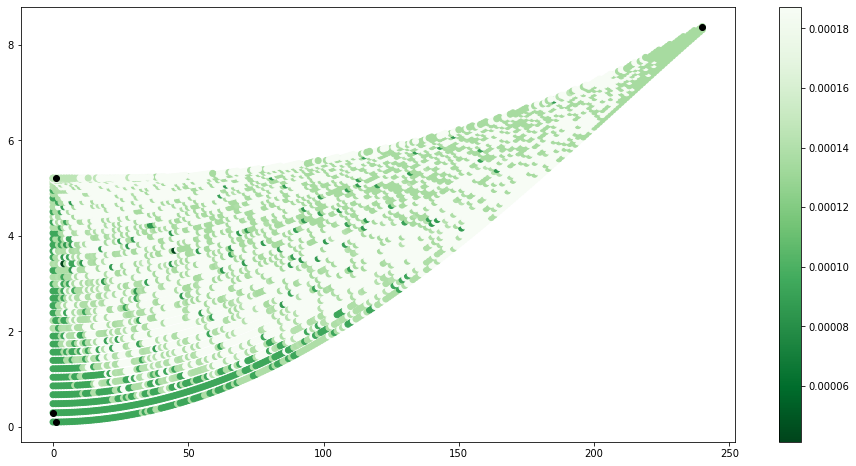

In [10]:
fig = plt.figure(figsize=(16,8))
ec  = plt.scatter(Leveljqn, LevelEeV, c=p, cmap='Greens_r')
plt.scatter(Leveljqn[LevelsVec], LevelEeV[LevelsVec], c='k')
cbar = plt.colorbar(ec)

In [11]:
#p2         = np.zeros(NLevels)
Vec        = np.zeros(NLevels)
for iIter in range(iIter, NSamples):

    iLevel = np.random.choice(Levels, 1, p=p)[0]
    LevelsVec.append(iLevel)

    p1     = 1. / np.maximum(Rates[iLevel,:], MinRate)
    p2    += p1 / np.sum(p1) 
    p      = p2 / (iIter+1)
    
#     Vec    = Rates[iLevel,:]
# #     Vec[iLevel] = 0.0
#     p1     = 1. - Vec/np.sum(Vec)
#     p2    += p1/np.sum(p1)
#     p      = p2 / (Iter+1)

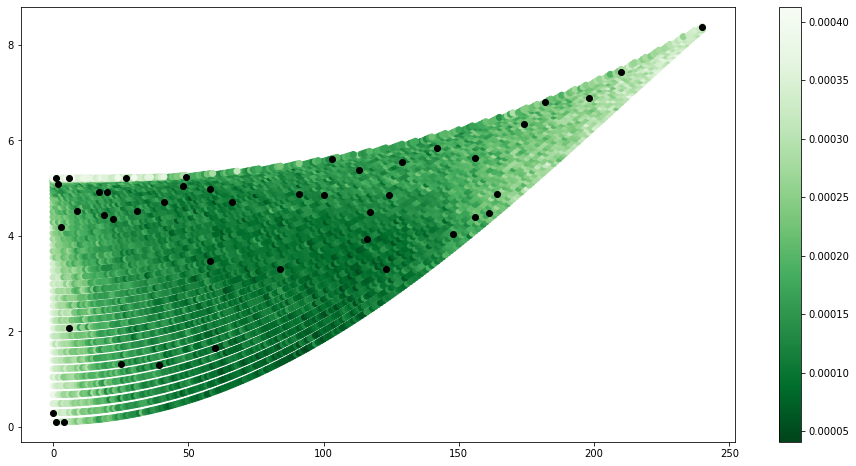

In [12]:
fig = plt.figure(figsize=(16,8))
ec  = plt.scatter(Leveljqn, LevelEeV, c=p, cmap='Greens_r')
plt.scatter(Leveljqn[LevelsVec], LevelEeV[LevelsVec], c='k')
cbar = plt.colorbar(ec)

<BarContainer object of 45 artists>

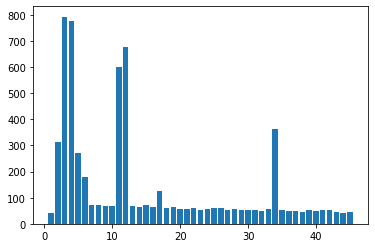

In [13]:
LevelsPerBin = np.zeros(NGroups, dtype=int)

for iLevel in range(NLevels):
    LevelsPerBin[LevelToBin[iLevel]] += 1
    
plt.bar(np.arange(NGroups)+1, LevelsPerBin)

<BarContainer object of 45 artists>

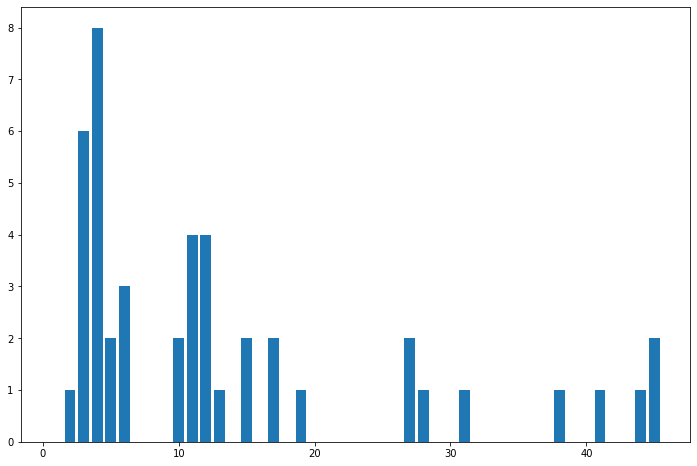

In [14]:
LevelsCount = np.zeros(NGroups, dtype=int)

for iLevel in LevelsVec:
    LevelsCount[LevelToBin[iLevel]] += 1

plt.figure(figsize=(12,8))
plt.bar(np.arange(NGroups)+1, LevelsCount)

(array([6., 1., 0., 3., 4., 8., 9., 5., 4., 5.]),
 array([1.0000e+00, 6.1230e+02, 1.2236e+03, 1.8349e+03, 2.4462e+03,
        3.0575e+03, 3.6688e+03, 4.2801e+03, 4.8914e+03, 5.5027e+03,
        6.1140e+03]),
 <BarContainer object of 10 artists>)

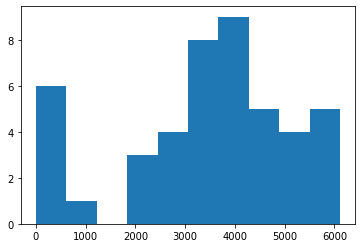

In [15]:
plt.hist(LevelsVec)

## 